In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import re
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

import gensim
from gensim import corpora

###**Preprocessing**

In [ ]:
df = pd.read_csv("data_tweet.csv")
df.head()

,LANGUAGE,LOCATION,SENDER,MESSAGE,Impressions,NUMBER_FOLLOWERS,RETWEET_COUNT,Twitter Likes,IS_VERIFIED,HAS_URL,...,IS_QUOTE,IS_RETWEET,DATE,TIME,IS_IN_REPLY_TO,IS_NEWS_AGENCY,TWEET_COUNT,IS_MEDIA,IS_GOVT,IS_PEOPLE
0,en,USA,TurnKyBlue,RT @TristanSnell Get rid of train safety rules...,4414.0,4414.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:56:12,NaN,NaN,NaN,0,0,1
1,en,NaN,jrbkjrbk,RT @realTuckFrumper Ohio Sues Norfolk Southern...,1011.0,1011.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2023-03-14,21:56:03,NaN,NaN,NaN,0,0,1
2,en,NaN,camoxendale,RT @SenJeffMerkley We need accountability from...,990.0,990.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:55:12,NaN,NaN,NaN,0,0,1
3,en,NaN,strongfemchar,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,64.0,64.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2023-03-14,21:54:42,NaN,NaN,NaN,0,0,1
4,en,NaN,Waywow,RT @NEWSMAX A new poll finds the majority of A...,2.0,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2023-03-14,21:54:29,NaN,NaN,NaN,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85220 entries, 0 to 85219
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LANGUAGE          85220 non-null  object 
 1   LOCATION          49974 non-null  object 
 2   SENDER            85220 non-null  object 
 3   MESSAGE           85220 non-null  object 
 4   Impressions       60294 non-null  float64
 5   NUMBER_FOLLOWERS  85220 non-null  float64
 6   RETWEET_COUNT     71853 non-null  float64
 7   Twitter Likes     60294 non-null  float64
 8   IS_VERIFIED       85220 non-null  float64
 9   HAS_URL           85220 non-null  float64
 10  IS_REPLY          85220 non-null  float64
 11  IS_QUOTE          85220 non-null  float64
 12  IS_RETWEET        85220 non-null  float64
 13  DATE              85220 non-null  object 
 14  TIME              85220 non-null  object 
 15  IS_IN_REPLY_TO    24926 non-null  float64
 16  IS_NEWS_AGENCY    24926 non-null  float6

In [ ]:
# remove stopwords (not impacting sentiment analysis) and punctuations
stop_words = set(stopwords.words('english')) - set(["no", "not", "nor", "against", "aren't", "couldn't", "didn't", 
                                                   "doesn't", "don't", "haven't", "hadn't", "hasn't", "isn't", "mightn't",
                                                   "mustn't", "needn't", "shouldn't", "wasn't", "weren't", "wouldn't"])
tokenizer = RegexpTokenizer(r'\w+')

# normalize pos tags
lemmatizer = WordNetLemmatizer()

def pos_tagger(nltk_tag):
  if nltk_tag.startswith('J'):
      return wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return wordnet.VERB
  elif nltk_tag.startswith('N'):
      return wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return wordnet.ADV
  else:         
      return None

In [ ]:
# lemmatize each token with pos tag
def lemma_token(row):
  wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), row))
  lemmatized = []
  for word, tag in wordnet_tagged:
    if tag is None:
        # if there is no available tag, just append the original token
        lemmatized.append(word)
    else:       
        # else use the pos tag to lemmatize the token
        lemmatized.append(lemmatizer.lemmatize(word, tag))
  return lemmatized

In [ ]:
# remove urls
df['Message_no_url'] = df['MESSAGE'].apply(lambda x: " ".join([word for word in x.split(" ") if not(word.startswith("https://"))]))

# tokenize MESSAGE and remove stopwords
df['Text'] = df['Message_no_url'].map(tokenizer.tokenize)
df['Text'] = df['Text'].apply(lambda x : nltk.pos_tag([item.lower() for item in x if item.lower() not in stop_words]))

# apply lemmatization and reset index
df['Text'] = df['Text'].apply(lambda row : lemma_token(row))
df = df.reset_index(drop=True)

In [ ]:
# join words
df['T_text'] = df['Text'].apply(lambda row : " ".join(row))

In [ ]:
df.head()

,LANGUAGE,LOCATION,SENDER,MESSAGE,Impressions,NUMBER_FOLLOWERS,RETWEET_COUNT,Twitter Likes,IS_VERIFIED,HAS_URL,...,TIME,IS_IN_REPLY_TO,IS_NEWS_AGENCY,TWEET_COUNT,IS_MEDIA,IS_GOVT,IS_PEOPLE,Message_no_url,Text,T_text
0,en,USA,TurnKyBlue,RT @TristanSnell Get rid of train safety rules...,4414.0,4414.0,0.0,0.0,0.0,0.0,...,21:56:12,NaN,NaN,NaN,0,0,1,RT @TristanSnell Get rid of train safety rules...,"[rt, tristansnell, get, rid, train, safety, ru...",rt tristansnell get rid train safety rule get ...
1,en,NaN,jrbkjrbk,RT @realTuckFrumper Ohio Sues Norfolk Southern...,1011.0,1011.0,0.0,0.0,0.0,1.0,...,21:56:03,NaN,NaN,NaN,0,0,1,RT @realTuckFrumper Ohio Sues Norfolk Southern...,"[rt, realtuckfrumper, ohio, sue, norfolk, sout...",rt realtuckfrumper ohio sue norfolk southern t...
2,en,NaN,camoxendale,RT @SenJeffMerkley We need accountability from...,990.0,990.0,0.0,0.0,0.0,0.0,...,21:55:12,NaN,NaN,NaN,0,0,1,RT @SenJeffMerkley We need accountability from...,"[rt, senjeffmerkley, need, accountability, nor...",rt senjeffmerkley need accountability norfolk ...
3,en,NaN,strongfemchar,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,64.0,64.0,0.0,0.0,0.0,0.0,...,21:54:42,NaN,NaN,NaN,0,0,1,RT @nicksortor 🚨 #BREAKING: The State of Ohio ...,"[rt, nicksortor, break, state, ohio, sue, norf...",rt nicksortor break state ohio sue norfolk sou...
4,en,NaN,Waywow,RT @NEWSMAX A new poll finds the majority of A...,2.0,2.0,0.0,0.0,0.0,1.0,...,21:54:29,NaN,NaN,NaN,0,0,1,RT @NEWSMAX A new poll finds the majority of A...,"[rt, newsmax, new, poll, find, majority, ameri...",rt newsmax new poll find majority american wan...


###**Sentiment Analysis**

1. change threshold: compare with labels
2. **research on phrases**
3. default stopwords in dictionary
4. perform on different groups

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('averaged_perceptron_tagger')
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
#perform sentiment analysis using vader
sia = SentimentIntensityAnalyzer()
scores= [sia.polarity_scores(text)['compound'] for text in df['T_text']]

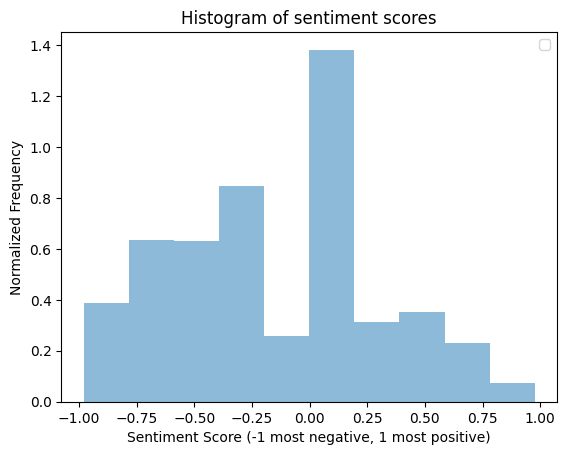

In [ ]:
#The histogram of sentiment scores
plt.hist(scores,density=True,alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel('Sentiment Score (-1 most negative, 1 most positive)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of sentiment scores')
plt.show()

####**words**

In [ ]:
add_stopwords = ['rt','train','southern','east','derailment','norfolk','palestine','february','u','ohio']
def countpos(indices):
  adj_counter = Counter()
  noun_counter = Counter()
  verb_counter = Counter()
  for row in indices:
    for item in nltk.pos_tag(row):
      if item[0] not in add_stopwords:
        if item[1].startswith('J'):
          orig_adj=item[0]
          adj_counter[orig_adj]+=1
        elif item[1].startswith('N'):
          orig_noun=item[0]
          noun_counter[orig_noun]+=1
        elif item[1].startswith('V'):
          orig_verb=item[0]
          verb_counter[orig_verb]+=1
  return adj_counter,noun_counter,verb_counter

In [ ]:
# create a function to get sentiment and product slices
def sentiment_product(sentiment, texts):
  sentimentproduct = []
  if sentiment == 'positive':
    for i in range(len(texts)):
      if scores[i] != None and scores[i] > 0:
        text_list = df["Text"][i]
        sentimentproduct.append(text_list)
  if sentiment == 'negative':
    for i in range(len(texts)):
      if scores[i] != None and scores[i] < 0:
        text_list = df["Text"][i]
        sentimentproduct.append(text_list)
  return sentimentproduct

In [ ]:
negative = sentiment_product('negative', df['T_text'])
positive = sentiment_product('positive', df['T_text'])

In [ ]:
countpos_negative=countpos(negative)
countpos_positive=countpos(positive)

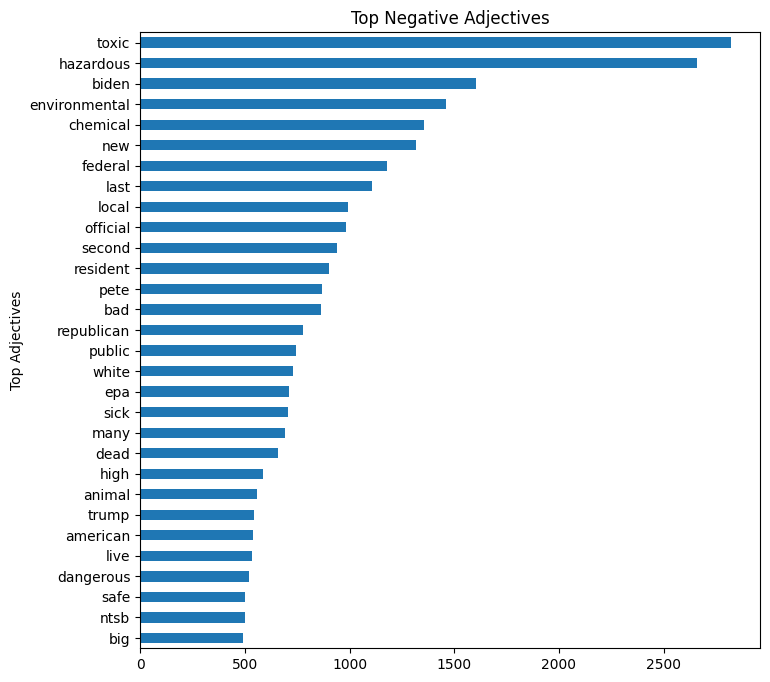

In [ ]:
pd.DataFrame(countpos_negative[0].most_common()[:30]).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top Negative Adjectives',
             xlabel='Top Adjectives',ylabel='Frequency',legend=False,).invert_yaxis()

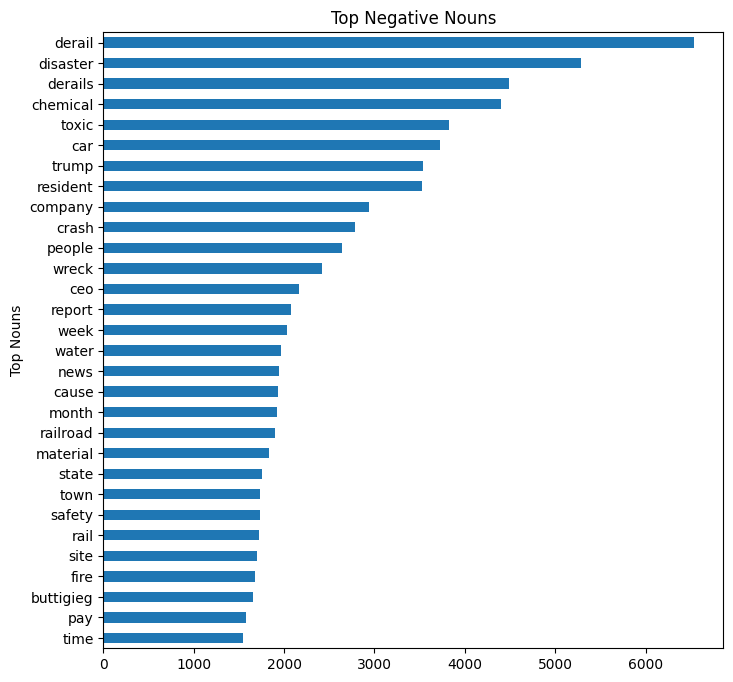

In [ ]:
pd.DataFrame(countpos_negative[1].most_common()[:30]).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top Negative Nouns',
             xlabel='Top Nouns',ylabel='Frequency',legend=False,).invert_yaxis()

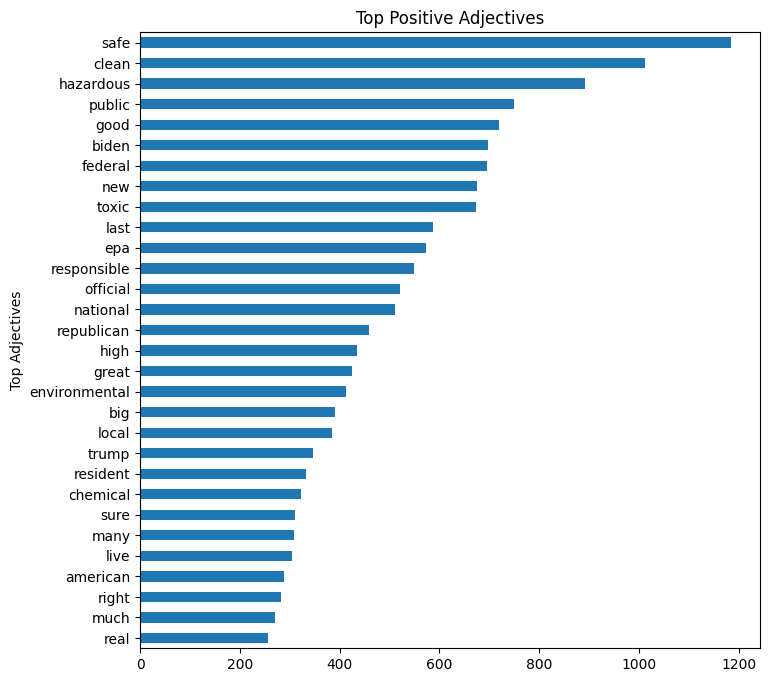

In [ ]:
pd.DataFrame(countpos_positive[0].most_common()[:30]).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top Positive Adjectives',
             xlabel='Top Adjectives',ylabel='Frequency',legend=False,).invert_yaxis()

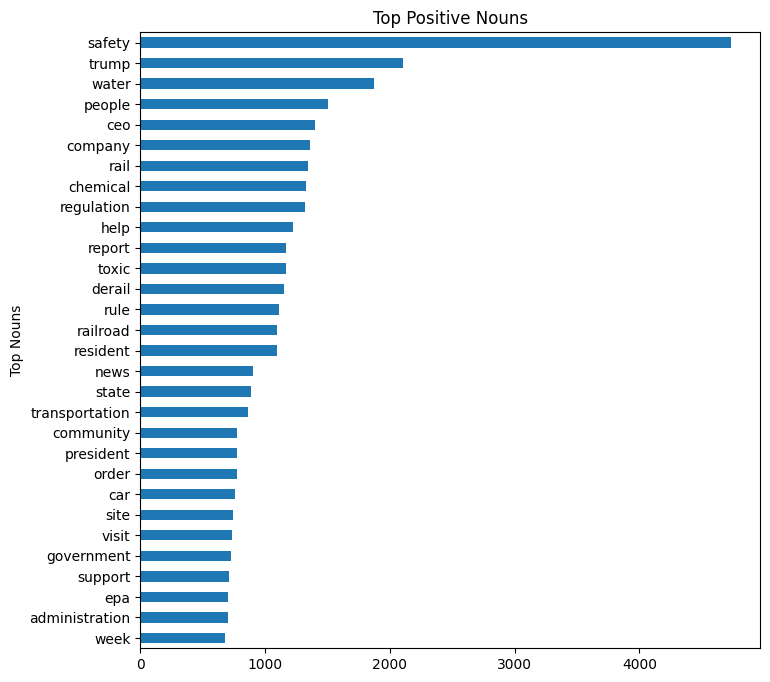

In [ ]:
pd.DataFrame(countpos_positive[1].most_common()[:30]).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top Positive Nouns',
             xlabel='Top Nouns',ylabel='Frequency',legend=False,).invert_yaxis()

####**n-gram**

In [ ]:
stop_word_list=stopwords.words('english') + add_stopwords

In [ ]:
negative_text = [" ".join(row) for row in negative]
positive_text = [" ".join(row) for row in positive]

[('toxic chemical', 1963), ('hazardous material', 1636), ('another derails', 1370), ('derails alabama', 1110), ('pete buttigieg', 1104), ('vinyl chloride', 959), ('shelter place', 922), ('another derail', 887), ('ceo testifies', 711), ('car derail', 707), ('carry hazardous', 706), ('alabama hour', 674), ('dump truck', 643), ('derails springfield', 629), ('cargo derail', 615), ('official say', 593), ('toxic wreck', 577), ('hour ceo', 550), ('biden administration', 544), ('chemical spill', 535), ('rail worker', 528), ('car cargo', 516), ('chemical derail', 515), ('hazardous chemical', 505), ('testifies congress', 485), ('north carolina', 464), ('carry toxic', 461), ('donald trump', 457), ('town hall', 453), ('environmental disaster', 452), ('toxic waste', 452), ('blame trump', 442), ('derail near', 434), ('alan shaw', 433), ('calhoun county', 421), ('toxic disaster', 419), ('last month', 379), ('near springfield', 378), ('transportation secretary', 378), ('ceo alan', 373), ('two week', 3

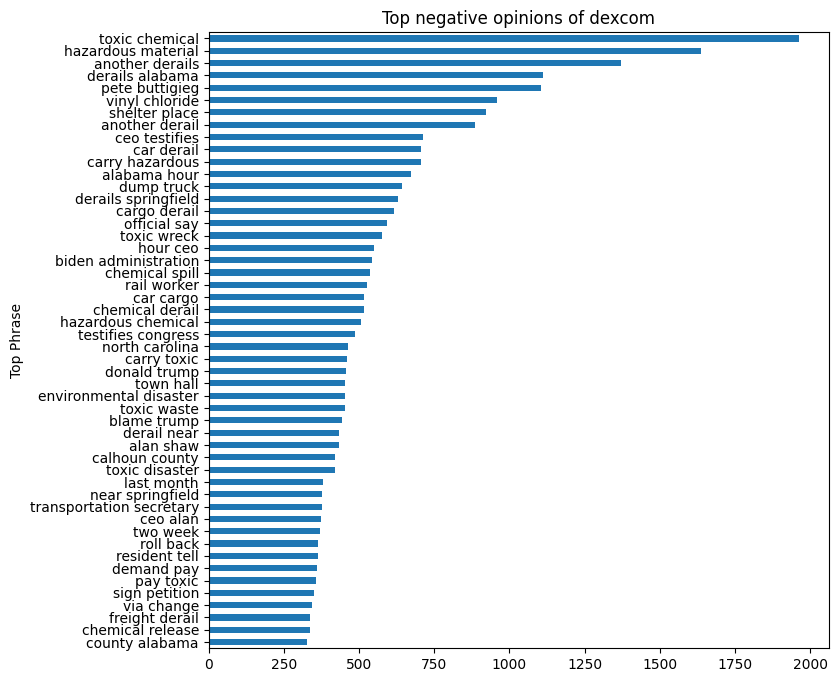

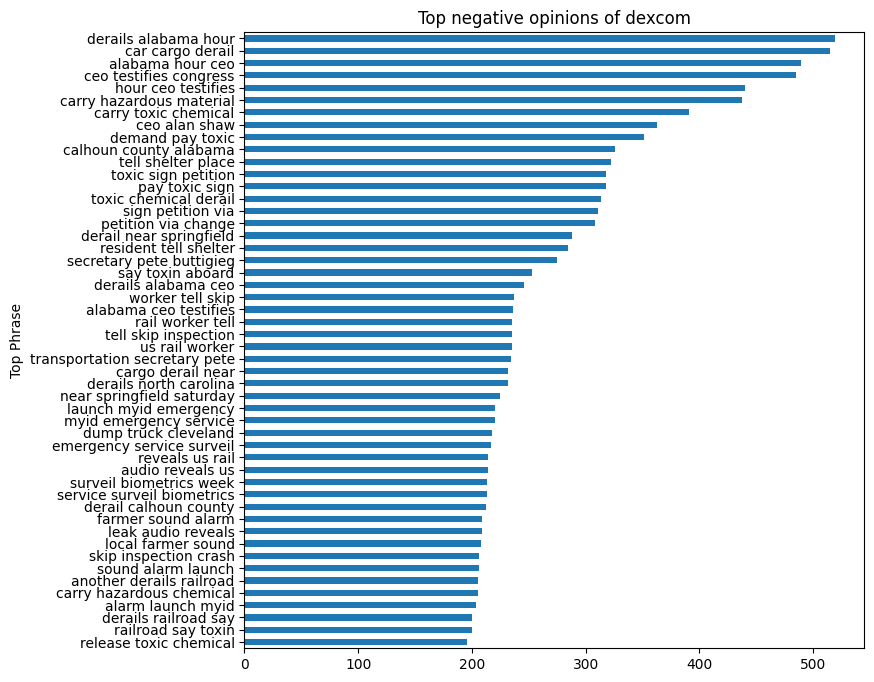

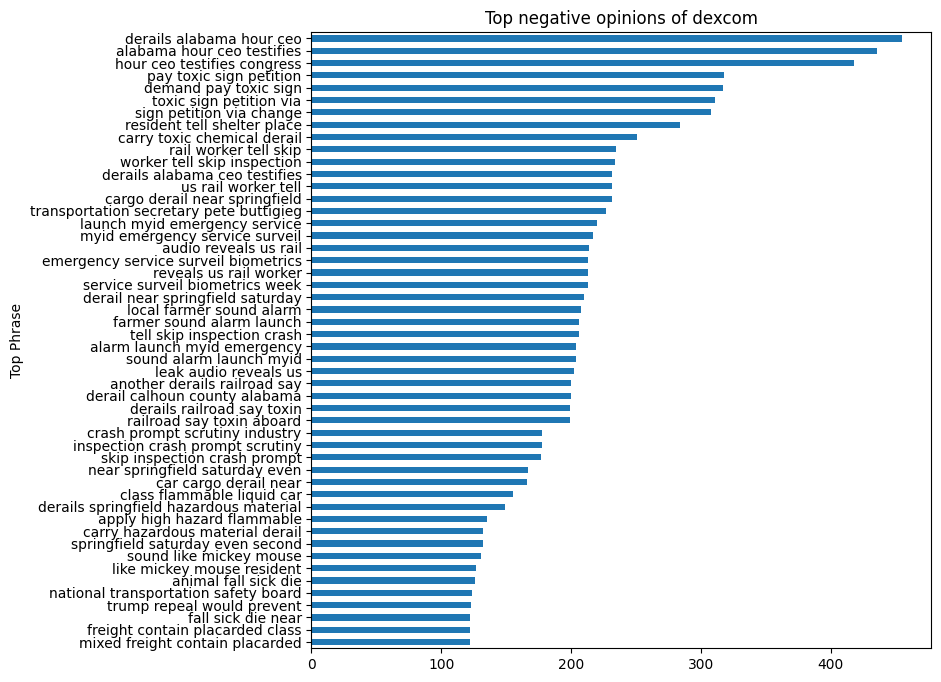

In [ ]:
## Top negative opinions of dexcom
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(negative_text)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50]).sort_values(by=[1],ascending=True).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top negative opinions',
             xlabel='Top Phrase',ylabel='Frequency',legend=False)

[('safety rule', 669), ('safety regulation', 563), ('hazardous material', 517), ('safety board', 487), ('north carolina', 482), ('rail safety', 482), ('toxic chemical', 461), ('derails north', 460), ('carolina danger', 453), ('transportation safety', 426), ('national transportation', 420), ('danger public', 395), ('public report', 391), ('epa order', 326), ('alan shaw', 312), ('ceo alan', 303), ('pete buttigieg', 300), ('high hazard', 295), ('ceo apologize', 286), ('order clean', 279), ('carry hazardous', 271), ('roll back', 269), ('would apply', 253), ('donald trump', 251), ('trump administration', 249), ('chemical spill', 239), ('mike dewine', 237), ('rail company', 230), ('fox news', 229), ('effect would', 227), ('apply derail', 224), ('biden administration', 224), ('last month', 223), ('water safe', 220), ('hazard cargo', 219), ('vinyl chloride', 219), ('categorize high', 217), ('even safety', 215), ('look like', 198), ('million dollar', 198), ('official say', 195), ('still effect'

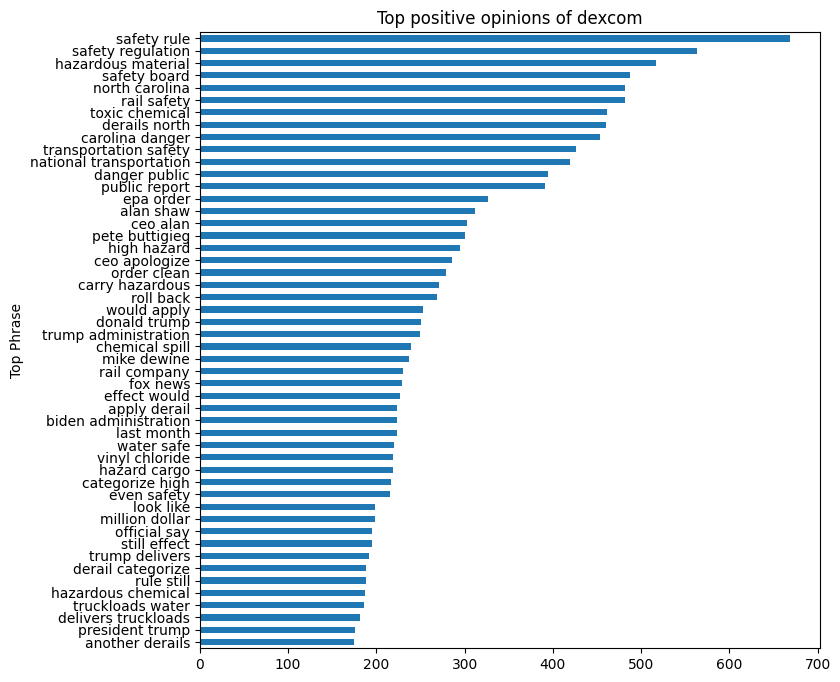

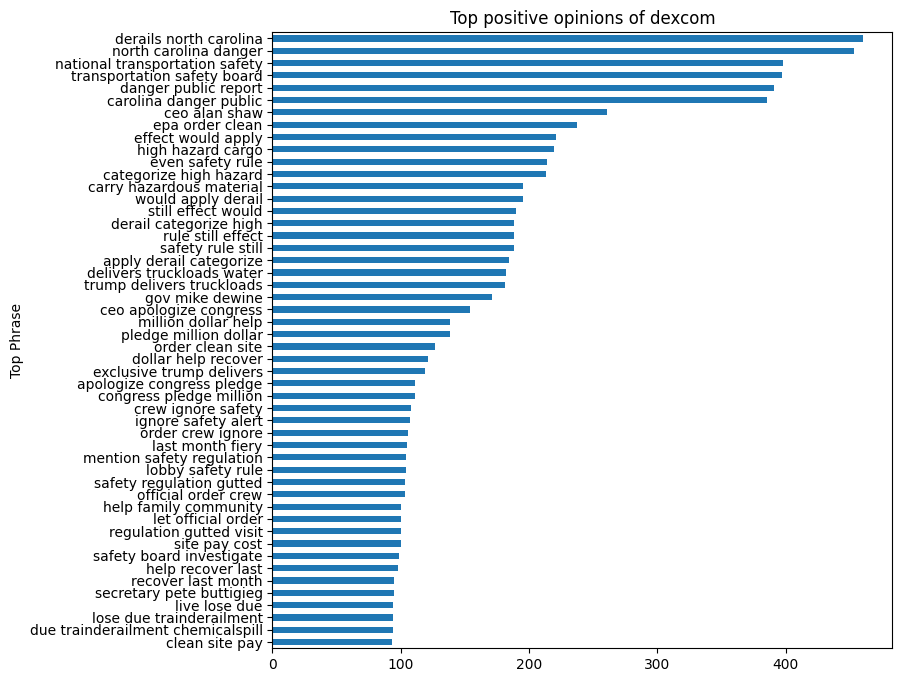

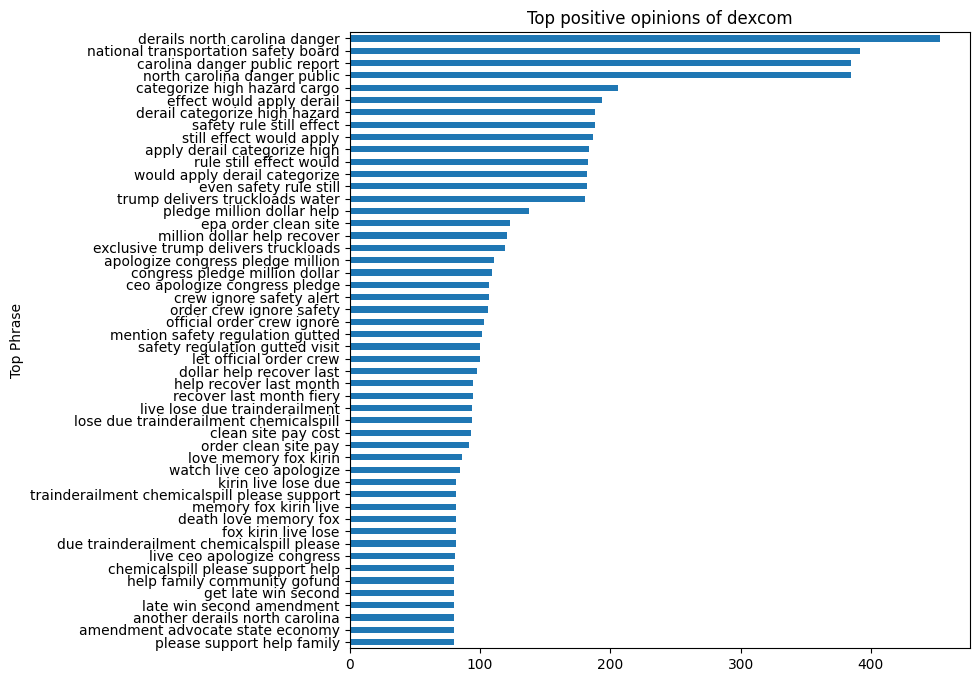

In [ ]:
## Top positive opinions of dexcom
for i in range(2, 5):
  # text = list of strings
  vectorizer = CountVectorizer(token_pattern = r'\b[a-zA-Z]+\b', lowercase = True, analyzer='word', stop_words = stop_word_list, ngram_range=(i, i))
  x = vectorizer.fit_transform(positive_text)

  wordcount = dict(pd.DataFrame(x.toarray(), columns = vectorizer.get_feature_names_out()).sum(axis=0))
  print(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50])

  pd.DataFrame(sorted(wordcount.items(), key = lambda x: x[1], reverse=True)[:50]).sort_values(by=[1],ascending=True).plot.barh(
             x=0,y=1,figsize=(8,8),title='Top positive opinions',
             xlabel='Top Phrase',ylabel='Frequency',legend=False)